# Deterministic Model 02: Nastavení modelových parametrů a proces modelování.

In [1]:
# Instalace potřebných knihoven
#%pip install pandas
#%pip install numpy

#%pip install seaborn

In [2]:
# Import potřebných knihoven
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Načtení reálných dat a dat digitálního kladečského plánu

In [3]:
# Soubor je načten a přiřazen do proměnné ‚df"
other_path = '../../data/02_DetermModel/merged_data.csv'
df = pd.read_csv(other_path, header=0)

In [4]:
# Zobrazení prvních 5 řádků datasetu
print('Prvních 5 řádků datového rámce')
df.head(5)

Prvních 5 řádků datového rámce


,id,type_brick,type,rotation,x,y,z,layer,pallet,dist,start_to_verif,verif_to_dest,dest_to_end,total_time
0,1,CORNER,2,90,220,95,0,1,1,2731,6,17,18,41
1,2,HALF,3,90,220,252,0,1,1,2596,3,17,16,36
2,4,BASIC,1,90,220,690,0,1,2,2350,6,14,17,37
3,6,BASIC,1,90,220,1190,0,1,4,1804,7,14,14,35
4,9,BASIC,1,90,220,1940,0,1,7,1454,8,13,24,45


### Definice a nastavení parametrů robotického systému

In [5]:
# SPECIFIKACE ROBOTICKÉHO SYSTÉMU

speed_max_load = 0.5      # m/s, maximální rychlost TCP při manipulaci s prvkem (se zátěží)
speed_max_unload = 1.0    # m/s, maximální rychlost TCP bez zátěže
accel = 1                 # m/s^2, zrychlení TCP

# výpočet času potřebného k dosažení maximální rychlosti
time_to_max_load_speed = speed_max_load / accel
dist_to_max_load_speed = (1/2) * accel * time_to_max_load_speed  # uražená dráha při akceleraci

# výpočet času potřebného k dosažení 0 rychlosti
time_to_max_unload_speed = speed_max_unload / accel
dist_to_max_unload_speed = (1/2) * accel * time_to_max_unload_speed  # uražená dráha při deakceleraci

# pracovní dosah robotického ramene
range_max = 3_904         # mm, maximální pracovní dosah
range_min = 1_912         # mm, minimální pracovní dosah (orientační)

# SPECIFIKACE TECHNOLOGICKÉHO PROCESU ZDĚNÍ

time_suck_on = 1.5        # s, doba přisátí zdicího prvku
time_suck_off = 0.5       # s, doba odsátí (uvolnění) prvku
time_verif_refer = 3.5    # s, doba pohybu z místa ověření do referenčního bodu
time_refer_pallete = 2.1  # s, doba pohybu z referenčního bodu k paletě

# SOUŘADNICE REFERENČNÍHO BODU

refer_x = 500             # mm, souřadnice X referenčního bodu
refer_y = 2_450           # mm, souřadnice Y referenčního bodu
refer_z = 1_500           # mm, souřadnice Z referenčního bodu

# POLOHA ROBOTICKÉHO RAMENE

robot_x = 2_250           # mm, souřadnice X základny robotu
robot_y = 2_420           # mm, souřadnice Y základny robotu
robot_z = 1_000           # mm, souřadnice Z základny robotu

# PARAMETRY SIMULACE

grid_simulation = 100     # mm, krok (rozlišení) simulační mřížky

### Výpočet vycházející z reálných dat

In [6]:
# průměrná doba přesunu z palety na ověřovací stůl
time_pallete_verif = df['start_to_verif'].mean() + time_suck_on
time_pallete_verif

np.float64(9.88679245283019)

### Definice funkce pro výpočet celkové doby pracovního cyklu

In [7]:
def simulate_time(dist):
    """
    Funkce pro výpočet celkové doby pracovního cyklu robotického zdění.

    Parametry:
    dist (float): vzdálenost mezi referenčním bodem a cílovou polohou prvku [mm]

    Návratová hodnota:
    total_time (float): celková doba pracovního cyklu [s]
    """
    # pevné technologické časy (manipulace a přesuny mezi pevnými body)
    total_time = time_suck_on + time_pallete_verif
    total_time += time_suck_off + time_suck_on + time_verif_refer

    # pohyb s naloženým prvkem (převod mm → m)
    total_time += (dist - dist_to_max_load_speed) / 1_000 / speed_max_load

    # manipulace v cílové poloze a návrat
    total_time += time_suck_off + time_refer_pallete

    # pohyb bez zátěže (zpětný pohyb)
    total_time += (dist - dist_to_max_unload_speed) / 1_000 / speed_max_unload

    # započtení akceleračních časů
    total_time += time_to_max_load_speed + time_to_max_unload_speed
    return total_time

In [8]:
# Výpočet simulované celkové doby pracovního cyklu
# Pro každý řádek datového rámce je aplikována funkce simulate_time()
# na základě vzdálenosti 'dist'.
df['total_time_calc'] = df.apply(lambda x : simulate_time(x['dist']) , axis=1)
df.head()

,id,type_brick,type,rotation,x,y,z,layer,pallet,dist,start_to_verif,verif_to_dest,dest_to_end,total_time,total_time_calc
0,1,CORNER,2,90,220,95,0,1,1,2731,6,17,18,41,29.178792
1,2,HALF,3,90,220,252,0,1,1,2596,3,17,16,36,28.773792
2,4,BASIC,1,90,220,690,0,1,2,2350,6,14,17,37,28.035792
3,6,BASIC,1,90,220,1190,0,1,4,1804,7,14,14,35,26.397792
4,9,BASIC,1,90,220,1940,0,1,7,1454,8,13,24,45,25.347792


### Kalibrace reálných dat

In [9]:
# Výpočet kalibračního koeficientu
# Poměr průměrné reálné doby cyklu k průměrné simulované době cyklu
koeff_correction = df['total_time'].mean() / df['total_time_calc'].mean()

# Aplikace korekčního koeficientu na simulovaná data
# Cílem je přiblížit střední hodnotu modelu reálným měřením
df['total_time_calc'] = df['total_time_calc'] * koeff_correction

In [10]:
df.head()

,id,type_brick,type,rotation,x,y,z,layer,pallet,dist,start_to_verif,verif_to_dest,dest_to_end,total_time,total_time_calc
0,1,CORNER,2,90,220,95,0,1,1,2731,6,17,18,41,42.439435
1,2,HALF,3,90,220,252,0,1,1,2596,3,17,16,36,41.850378
2,4,BASIC,1,90,220,690,0,1,2,2350,6,14,17,37,40.776985
3,6,BASIC,1,90,220,1190,0,1,4,1804,7,14,14,35,38.394577
4,9,BASIC,1,90,220,1940,0,1,7,1454,8,13,24,45,36.867392


### Kontrola lineární vzdálenosti od referenčního bodu ke stěně

In [11]:
# Výpočet lineární (Eukleidovské) vzdálenosti mezi referenčním bodem
# a cílovou polohou zdicího prvku ve 3D prostoru
df['dist_linear'] = (
    (df['x'] - refer_x)**2 +
    (df['y'] - refer_y)**2 +
    ((df['z'] + 250) - refer_z)**2   # korekce výšky (např. uchopovací bod TCP)
)**(1/2)
df.head(10)

,id,type_brick,type,rotation,x,y,z,layer,pallet,dist,start_to_verif,verif_to_dest,dest_to_end,total_time,total_time_calc,dist_linear
0,1,CORNER,2,90,220,95,0,1,1,2731,6,17,18,41,42.439435,2680.844083
1,2,HALF,3,90,220,252,0,1,1,2596,3,17,16,36,41.850378,2544.033019
2,4,BASIC,1,90,220,690,0,1,2,2350,6,14,17,37,40.776985,2176.809592
3,6,BASIC,1,90,220,1190,0,1,4,1804,7,14,14,35,38.394577,1796.802716
4,9,BASIC,1,90,220,1940,0,1,7,1454,8,13,24,45,36.867392,1378.767566
5,10,BASIC,1,90,220,2190,0,1,8,1409,8,14,12,34,36.671040,1307.096018
6,11,BASIC,1,90,220,2440,0,1,9,1408,8,12,14,34,36.666676,1281.015222
7,12,BASIC,1,90,220,2690,0,1,10,1450,6,13,13,32,36.849938,1303.265130
8,13,BASIC,1,90,220,2940,0,1,11,1532,10,10,27,47,37.207736,1371.495534
9,14,BASIC,1,90,220,3190,0,1,12,1648,8,12,14,34,37.713889,1479.357969


### Porovnání reálných a kalibrovaných dat

<Axes: xlabel='type_brick', ylabel='total_time'>

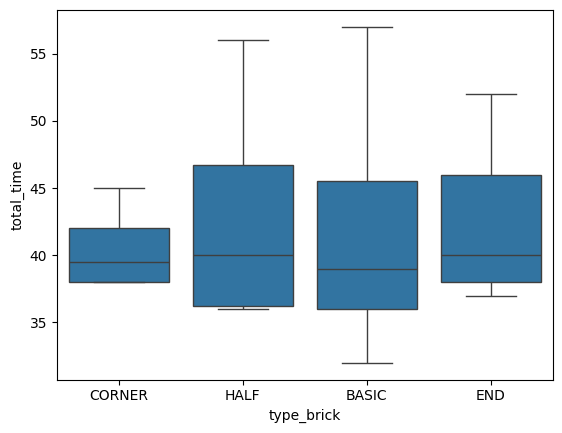

In [12]:
sns.boxplot(x='type_brick', y="total_time", data=df)

<Axes: xlabel='type_brick', ylabel='total_time_calc'>

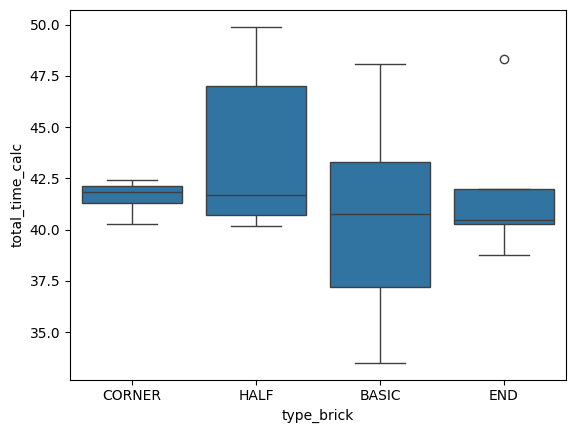

In [13]:
sns.boxplot(x='type_brick', y="total_time_calc", data=df)

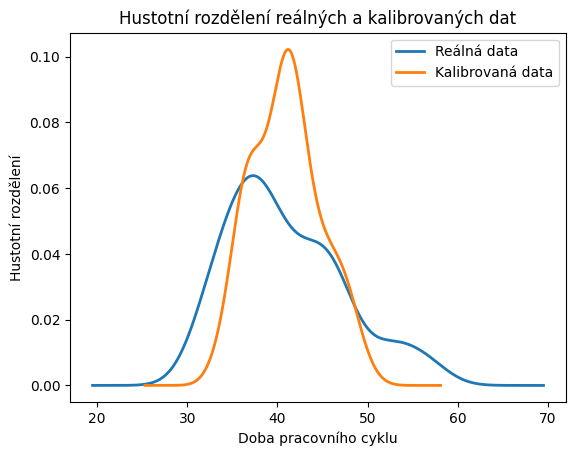

In [14]:
# Graf: Hustotní rozdělení reálných a kalibrovaných dat
df['total_time'].plot.density(bw_method='scott', linestyle='-', linewidth=2, label='Reálná data')
df['total_time_calc'].plot.density(bw_method='scott', linestyle='-', linewidth=2, label='Kalibrovaná data')
plt.legend()
plt.xlabel("Doba pracovního cyklu")
plt.ylabel("Hustotní rozdělení")
plt.title('Hustotní rozdělení reálných a kalibrovaných dat')
plt.show()

### Simulace přípustných pracovních bodů v prostředí Rhinoceros a Grasshopper (viz. model Rhino)

In [15]:
# Soubor je načten a přiřazen do proměnné ‚df_allowed_points"
other_path = '../../data/02_DetermModel/allowed_points.csv'
df_allowed_points = pd.read_csv(other_path, header=0)

In [16]:
# Změna datového typu sloupců a zobrazení prvních 5 řádků datasetu
df_allowed_points[['x','y','z']] = df_allowed_points[['x','y','z']].astype(int)
df_allowed_points.head(5)


,x,y,z
0,74,459,1284
1,-90,4908,2217
2,522,3074,26
3,425,2247,2739
4,516,3425,1590


### Generování deterministických simulačních dat

In [17]:
# Vytvoření simulačního datového rámce z množiny přípustných bodů
df_sim = df_allowed_points

# Výpočet Eukleidovské vzdálenosti od referenčního bodu
df_sim['dist'] = (
    (df_sim['x'] - refer_x)**2 +
    (df_sim['y'] - refer_y)**2 +
    ((df_sim['z'] + 250) - refer_z)**2
)**(1/2)

# Výpočet deterministické doby pracovního cyklu
df_sim['total_time'] = df_sim.apply(
    lambda x: simulate_time(x['dist']),
    axis=1
)

# Aplikace kalibračního koeficientu (globální lineární korekce modelu)
df_sim['total_time'] = df_sim['total_time'] * koeff_correction

# Náhled prvních řádků simulovaného datasetu
df_sim.head()

,x,y,z,dist,total_time
0,74,459,1284,2036.347957,39.408400
1,-90,4908,2217,2706.465038,42.332379
2,522,3074,26,1374.058223,36.518575
3,425,2247,2739,1504.644476,37.088373
4,516,3425,1590,1032.705670,35.029123


In [18]:
# Základní deskriptivní statistika simulovaného datasetu
df_sim.describe()

,x,y,z,dist,total_time
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,1422.944700,1336.856500,1374.817600,2435.292585,41.149149
std,1440.916105,1512.725045,805.317921,1090.305852,4.757424
min,-99.000000,-99.000000,0.000000,64.101482,30.802730
25%,248.000000,202.000000,676.000000,1577.850196,37.407798
50%,599.500000,521.000000,1374.500000,2402.055568,41.004123
75%,2591.250000,2435.000000,2076.000000,3159.976186,44.311223
max,4599.000000,4949.000000,2749.000000,5026.495598,52.455566


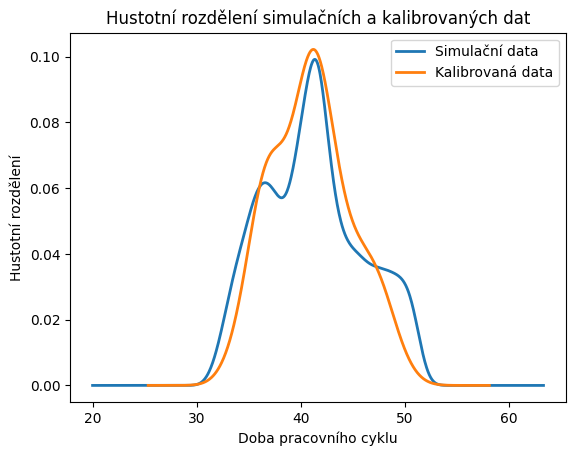

In [19]:
# Graf: Hustotní rozdělení simulačních a kalibrovaných dat
df_sim['total_time'].plot.density(bw_method='scott', linestyle='-', linewidth=2, label='Simulační data')
df['total_time_calc'].plot.density(bw_method='scott', linestyle='-', linewidth=2, label='Kalibrovaná data')

plt.xlabel("Doba pracovního cyklu")
plt.ylabel("Hustotní rozdělení")
plt.title('Hustotní rozdělení simulačních a kalibrovaných dat')

plt.legend()
plt.show()

### Export datové sady do formátu CSV

In [20]:
df_sim.to_csv("../../data/02_DetermModel/model_data.csv", index=False)
df.to_csv("../../data/02_DetermModel/model_data_real.csv", index=False)

### Autor / Organizace / Datum

Vjačeslav Usmanov, ČVUT v Praze, Fakulta stavební

###### Přehled změn


|  Datum (YYYY-MM-DD) |  Verze | Autor změny  |  Popis změny |
|---|---|---|---|
| 2026-01-24 | 1.1 | Vjačeslav Usmanov| added DM_02_Model_Parameters.ipynb |
| 2026-02-14 | 1.2 | Vjačeslav Usmanov| changed DM_02_Model_Parameters.ipynb |